# Cosmological Parameters Calculation
### Collaborators: Eli Gendreau-Distler, Brianna Peck, and Dex Bhadra

## Summary
In this notebook, we will outline our procedure for calculating the cosmological parameters $\Omega_{m,0}$, $\Omega_{\Lambda,0}$, and $H_0$ from observations of Type 1a supernovae. We will start with datasets describing supernovae redshifts and luminosity distances from several important studies in the field. Using equations from the course, we will derive a relationship between redshift and luminosity distance in terms of the cosmological parameters. Then we will fit our data to this model in order to solve for the best fit values of $\Omega_{m,0}$, $\Omega_{\Lambda,0}$, and $H_0$. We will separately determine the best fit values of these parameters by sampling the phase space and calculating the probability for the true values to lie within each small region of phase space. After calculating $\Omega_{m,0}$, $\Omega_{\Lambda,0}$, and $H_0$, we will integrate the Friedmann equation to illustrate the evolution of the universe under the predicted model. Lastly, we will conclude by comparing our parameters to the accepted results and discussing the implications of these results for the history and fate of our universe.

## Preliminaries
Let's start by importing the packages we will need, defining the relevant constants, and reading in the redshift and luminosity distance data.

In [1]:
# packages
import numpy as np
import scipy.integrate as integrate
import scipy.optimize as opt
import matplotlib.pyplot as plt
import csv
from scipy.stats import chi2 as c2

In [14]:
plt.rcParams.update({'font.size': 25})

In [2]:
# constant
c = 2.99792458 * 1e5 # units: km/s

In [3]:
data_snls = np.genfromtxt('snls_3rdyear_lcparams.txt')
redshift = data_snls.T[1]  # CMB-frame redshift
alpha = 1.4 # fit params
beta = 3.2 # fit params
b_band_lum = data_snls.T[4]
color_measure = data_snls.T[8]
stretch_factor = data_snls.T[6]
stretch_factor_error = data_snls.T[7]
b_band_lum_err = data_snls.T[5]
redshift = data_snls.T[1]
color_error = data_snls.T[9]
dist_mod = b_band_lum + alpha * (stretch_factor - 1) - beta * color_measure + 19
dist_mod_err = np.sqrt(b_band_lum_err**2 + (alpha*stretch_factor_error)**2 + (beta*color_error)**2)

lum_dist = 10**((dist_mod - 25)/5)
lum_dist_err = lum_dist * np.log(10) * dist_mod_err/5

## Model
In general, a light source's flux, luminosity, and distance are related by
$$F=\frac{L}{4\pi r^2}$$

When doing cosmology, we must make a few modifications to this simple equation to account for the expansion and (possible) curvature of the universe. First, since the universe may not be flat, the area over which the source's light spreads out is $A=4\pi S_k(r)^2$ where
$$S_k(r) = \begin{cases}
    R_0\sin{\left(\frac{r}{R_0}\right)}, & \kappa = +1\\
    r, & \kappa = 0\\
    R_0\sinh{\left(\frac{r}{R_0}\right)}, & \kappa = -1\\
\end{cases}$$

and $R_0$ is the universe's radius of curvature. As expected, this expression simplifies to $A=4\pi r^2$ in the case of a flat universe.

Next, because the universe is expanding, the wavelength at which we observe a photon is longer than the wavelength at which it was emitted. In particular, a photon emitted with wavelength $\lambda_e$ and energy $E_e = \frac{hc}{\lambda_e}$ will have wavelength $\lambda_o = \frac{\lambda_e}{a(t_e)}$ and energy 
$$E_o = \frac{hc}{\lambda_o} = a(t_e) \frac{hc}{\lambda_e} = a(t_e)E_e = \frac{1}{1+z_e}E_e$$

when we observe it today. We can account for this by adding a factor of $\frac{1}{1+z_e}$ to the expression for the observed flux; that is,
$$F=\frac{L}{4\pi S_k(r)^2}\frac{1}{1+z_e}$$

We are not quite done yet, because we still need to incorporate the effect of cosmological time dilation. If two photons are emitted a time $\Delta t_e$ apart, then the time interval between when we observe the two photons is
$$\Delta t_o = \frac{a(t_o)}{a(t_e)}\Delta t_e = \frac{\Delta t_e}{a(t_e)} = (1+z_e)\Delta t_e$$

This means the observed flux is a factor of $\frac{1}{1+z_e}$ smaller than we previously calculated, seeing as the time interval between the arrival of successive photons is larger. Hence our final expression for the relationship between flux, luminosity, and distance (which now also depends on redshift) is
$$F = \frac{L}{4\pi S_k(r)^2}\frac{1}{(1+z_e)^2}$$

This expression can be simplified by defining the luminosity distance $d_L = S_k(r)(1+z_e)$ such that $F = \frac{L}{4\pi d_L^2}$. This relation almost gives us the desired expression relating $d_L$ and $z$, except that we still need to determine the comoving radial coordinate $r$. From the Friedmann-Robertson-Walker (FRW) metric for light moving radially inward, we can see that
$$ds^2 = 0 = -c^2dt^2 + a(t)^2dr^2$$
$$ dr^2 = c^2\frac{dt^2}{a(t)^2}$$
$$ dr = -c\frac{dt}{a(t)}$$
$$r = -\int_r^0 dr' = c\int_{t_e}^{t_0}\frac{dt}{a(t)} = c\int_{t_e}^{t_0}\frac{dt}{da}\frac{da}{a} = c\int_{a(t_e)}^{1}\frac{da}{\dot{a}a} = c\int_{a(t_e)}^{1}\frac{da}{a^2}\frac{a}{\dot{a}} = c\int_{a(t_e)}^{1}\frac{da}{a^2}\frac{1}{H(t)}$$

At this point, we can use the Friedmann equation for a matter- and dark energy-dominated universe to replace the Hubble parameter:
$$H(t)^2 = \frac{\dot{a}^2}{a^2} = H_0^2 \left(\frac{\Omega_{m,0}}{a^3} + \Omega_{\Lambda,0}+\frac{1-\Omega_0}{a^2}\right)$$
$$r=c\int_{a(t_e)}^{1}\frac{da}{a^2}\left[H_0^2 \left(\frac{\Omega_{m,0}}{a^3} + \Omega_{\Lambda,0}+\frac{1-\Omega_0}{a^2}\right)\right]^{-\frac{1}{2}}$$

We now need to convert the integration over the scale factor into an integration over the redshift. This can be accomplished using the substitution $a = \frac{1}{1+z}$ and $da = -\frac{dz}{(1+z)^2}$.
$$r=-c\int_{z_e}^{0}\frac{dz}{(1+z)^2}(1+z)^2\left[H_0^2 \left({\Omega_{m,0}}(1+z)^3 + \Omega_{\Lambda,0}+\left(1-\Omega_0\right)(1+z)^2\right)\right]^{-\frac{1}{2}}=cH_0^{-1}\int_0^{z_e}\left[{\Omega_{m,0}}(1+z)^3 + \Omega_{\Lambda,0}+\left(1-\Omega_0\right)(1+z)^2\right]^{-\frac{1}{2}}dz$$

In a matter- and dark energy-dominated universe, $\Omega_0 = \Omega_{m,0} + \Omega_{\Lambda,0}$. We can use this to simplify further:
\begin{aligned}
r&=cH_0^{-1}\int_0^{z_e}\left[{\Omega_{m,0}}(1+z)^3 + \Omega_{\Lambda,0}+\left(1-\Omega_{m,0}-\Omega_{\Lambda,0}\right)(1+z)^2\right]^{-\frac{1}{2}}dz\\
&=cH_0^{-1}\int_0^{z_e}\left[(1+z)^2 \left(\Omega_{m,0} + \Omega_{m,0}z- \Omega_{m,0}\right) + \Omega_{\Lambda,0}+(1+z)^2 - \Omega_{\Lambda,0}(1+z)^2 \right]^{-\frac{1}{2}}dz\\
&=cH_0^{-1}\int_0^{z_e}\left[(1+z)^2 \left( 1+\Omega_{m,0}z\right) + \Omega_{\Lambda,0}\left(1-1-2z-z^2\right) \right]^{-\frac{1}{2}}dz\\
&=cH_0^{-1}\int_0^{z_e}\left[(1+z)^2 \left( 1+\Omega_{m,0}z\right) -z(2+z) \Omega_{\Lambda,0} \right]^{-\frac{1}{2}}dz
\end{aligned}

We can now insert this expression into our equation for the luminosity distance.
$$d_L = S_k(r)(1+z_e) = (1+z_e)S_k\left(cH_0^{-1}\int_0^{z_e}\left[(1+z)^2 \left( 1+\Omega_{m,0}z\right) -z(2+z) \Omega_{\Lambda,0} \right]^{-\frac{1}{2}}dz\right)$$

To evaluate the $S_k(r)$ function, we will need to derive an expression for the radius of curvature $R_0$. In Problem Set 6, we derived that $R_0$ satisfies the equation
$$\frac{\kappa}{R_0^2} = \frac{H_0^2}{c^2}(\Omega_0-1)$$
$$R_0^2 = \frac{\kappa c^2}{H_0^2}\frac{1}{{\Omega_0 - 1}}$$

Notice that this expression for $R_0$ is always nonnegative because $\Omega_0 > 1$ when $\kappa = +1$ and $\Omega_0 < 1$ when $\kappa = -1$. This result can be used to rewrite the function $S_k(r)$ in the following form.
$$S_k(r) = \begin{cases}
    \frac{c}{H_0}\frac{1}{\sqrt{\Omega_0 -1}}\sin{\left(\frac{H_0}{c}\sqrt{\Omega_0 -1}r\right)}, & \kappa = +1\\
    r, & \kappa = 0\\
    \frac{c}{H_0}\frac{1}{\sqrt{1-\Omega_0}}\sinh{\left(\frac{H_0}{c}\sqrt{1-\Omega_0}r\right)}, & \kappa = -1\\
\end{cases}$$

Let's now define $\Omega_{k,0} = 1-\Omega_0$ and $\text{sinn}(x) = \begin{cases} \sin{(x)}, & \kappa = +1\\ x, & \kappa = 0\\ \sinh{(x)}, & \kappa = -1\\\end{cases}$. Then our expression for $S_k(r)$ can be further simplified to
\begin{aligned}
S_k(r) &= \begin{cases}
    \frac{c}{H_0}\vert\Omega_{k,0}\vert^{-\frac{1}{2}}\sin{\left(\frac{H_0}{c}\vert\Omega_{k,0}\vert^{\frac{1}{2}}r\right)}, & \kappa = +1\\
    r, & \kappa = 0\\
    \frac{c}{H_0}\vert\Omega_{k,0}\vert^{-\frac{1}{2}}\sinh{\left(\frac{H_0}{c}\vert\Omega_{k,0}\vert^{\frac{1}{2}}r\right)}, & \kappa = -1\\
\end{cases}\\
&= \frac{c}{H_0}\vert\Omega_{k,0}\vert^{-\frac{1}{2}}\text{sinn}{\left(\frac{H_0}{c}\vert\Omega_{k,0}\vert^{\frac{1}{2}}r\right)}
\end{aligned}

Inserting this expression into the equation for the luminosity distance, we obtain
\begin{aligned}
d_L &= (1+z_e)\frac{c}{H_0}\vert\Omega_{k,0}\vert^{-\frac{1}{2}}\text{sinn}\left(\frac{H_0}{c}\vert\Omega_{k,0}\vert^{\frac{1}{2}}cH_0^{-1}\int_0^{z_e}\left[(1+z)^2 \left( 1+\Omega_{m,0}z\right) -z(2+z) \Omega_{\Lambda,0} \right]^{-\frac{1}{2}}dz\right)\\
&=cH_0^{-1}(1+z_e)\vert\Omega_{k,0}\vert^{-\frac{1}{2}}\text{sinn}\left(\vert\Omega_{k,0}\vert^{\frac{1}{2}}\int_0^{z_e}\left[(1+z)^2 \left( 1+\Omega_{m,0}z\right) -z(2+z) \Omega_{\Lambda,0} \right]^{-\frac{1}{2}}dz\right)
\end{aligned}

This last line is exactly Equation (2) from Riess et al. (1998), so we have just derived the equation used to fit cosmological parameters in one of the original papers on the accelerating universe! Let's now write a Python function to compute the expression on the right side of this equation.

In [4]:
def D_L(z, omega_m, omega_lambda, H_0):
    omega_k = 1-omega_m-omega_lambda
    if (omega_k == 0): # handle this case separately to avoid division by zero errors
        def integrand(x):
            return 1/np.sqrt((1+x)**2*(1+omega_m*x) - x*(2+x)*omega_lambda)
        integral = integrate.quad(integrand,0,z)[0]
        r = c*integral/H_0
        return (1+z)*r
        
    prefactor = (c/H_0) * (1+z) * (1/np.sqrt(np.abs(omega_k)))
    def integrand(x):
        return 1/np.sqrt((1+x)**2 * (1+omega_m*x) - x * (2+x) * omega_lambda)
    integral = integrate.quad(integrand,0,z)[0]
    arg = np.sqrt(np.abs(omega_k)) * integral
    sinn = np.sin(arg) if omega_k <= 0 else np.sinh(arg)
    return prefactor * sinn

In [5]:
def D_L_helper(redshifts, omega_m, omega_lambda, H_0):
    return [D_L(z,omega_m,omega_lambda,H_0) for z in redshifts]

In [ ]:
bnds = ((0,0,60),(2,2,80))
popt, pcov = opt.curve_fit(D_L_helper, redshift, lum_dist, p0=[0.3,0.7,70], bounds = bnds, sigma = lum_dist_err)
omega_m, omega_lambda, H_0 = popt
omega_m_err, omega_lambda_err, H_0_err = np.sqrt(np.diag(pcov))

In [ ]:
print("Matter density: ", "{0:.3f}".format(omega_m), " ± ", "{0:.3f}".format(omega_m_err))
print("Dark energy density: ", "{0:.2f}".format(omega_lambda), " ± ", "{0:.2f}".format(omega_lambda_err))
print("Hubble constant: ", "{0:.2f}".format(H_0), " ± ", "{0:.2f}".format(H_0_err))

In [ ]:
plt.figure(figsize = (15,15))
zz = np.linspace(np.min(redshift),np.max(redshift),1000)
plt.errorbar(np.log(redshift),lum_dist,yerr=lum_dist_err,fmt='.',color='purple')
plt.errorbar(np.log(zz),D_L_helper(zz, omega_m, omega_lambda, H_0), linewidth=3,color='black')
plt.xlabel("$\log(z)$")
plt.ylabel("$D_L$ (Mpc)")
plt.legend(("Union Data","Best Fit Model"),loc='upper left')
plt.title("Luminosity Distance vs. Redshift (SCP Data)");

## Phase Space Sampling
An alternative method for finding the best fit values of the cosmological parameters is to uniformly sample the phase space and quantify how well each combination of parameters fits the data. We will start by sampling from the following ranges for the cosmological parameters:
$$ \Omega_{m,0} \in [0,1], \quad \Omega_{\Lambda,0} \in [0,1], \quad H_0 \in [60,80]$$

To evaluate the goodness of fit for each possible combination of parameters, we will compute the chi-squared statistic, which is defined by
$$\chi^2 = \sum_i \frac{(d_{obs,i}-d_{exp,i})^2}{d_{err,i}^2}$$

where the observed luminosity distances are $d_{obs,i}\pm d_{err,i}$, the expected luminosity distances (based on our choice of cosmological parameters) are $d_{exp,i}$, and the sum is taken over all data points.

In [59]:
num_points = 20

omega_m_range = np.linspace(0,1,num_points)
omega_lambda_range = np.linspace(0,1,num_points)
H_0_range = np.linspace(60,80,num_points)

omega_m_best = omega_m_range[0]
omega_lambda_best = omega_lambda_range[0]
H_0_best = H_0_range[0]
expected = D_L_helper(redshift, omega_m, omega_lambda, H_0)
chi2_best = np.sum((lum_dist - expected)**2/lum_dist_err**2)
k_best = 0

chi2_arr = np.zeros((num_points,num_points,num_points))

for i in np.arange(np.size(omega_m_range)):
    for j in np.arange(np.size(omega_lambda_range)):
        for k in np.arange(np.size(H_0_range)):
            omega_m = omega_m_range[i]
            omega_lambda = omega_lambda_range[j]
            H_0 = H_0_range[k]
            expected = D_L_helper(redshift, omega_m, omega_lambda, H_0)
            chi2 = np.sum((lum_dist - expected)**2/lum_dist_err**2)
            chi2_arr[i][j][k] = chi2
            if chi2 < chi2_best:
                omega_m_best = omega_m
                omega_lambda_best = omega_lambda
                H_0_best = H_0
                chi2_best = chi2
                k_best = k
                
print("Matter density: ", "{0:.2f}".format(omega_m_best))
print("Dark energy density: ", "{0:.2f}".format(omega_lambda_best))
print("Hubble constant: ", "{0:.2f}".format(H_0_best))

Matter density:  0.21
Dark energy density:  0.74
Hubble constant:  76.84


The best-fit values of $\Omega_{m,0}$, $\Omega_{\Lambda,0}$, and $H_0$ identified using phase space sampling lie within the error bars of the values calculated by fitting the model to the data directly. In addition, the plot above illustrates visually that the model produced by these best-fit parameters provides a good fit to the data.

At this point, we would like to create phase space plots to demonstrate which regions of the $(\Omega_{m,0},\Omega_{\Lambda,0})$ phase space are most likely to contain the true values. Since we will be visualizing these plots in 2D (taking the Hubble constant to be fixed at its best fit value), we might as well go ahead and fix $H_0$ now so that we can obtain better resolution in the other two parameters at the same computational cost.

In [60]:
num_points = 50

omega_m_range = np.linspace(0,1,num_points)
omega_lambda_range = np.linspace(0,1,num_points)

omega_m_best = omega_m_range[0]
omega_lambda_best = omega_lambda_range[0]
expected = D_L_helper(redshift, omega_m, omega_lambda, H_0_best)
chi2_best = np.sum((lum_dist - expected)**2/lum_dist_err**2)
k_best = 0

chi2_arr = np.zeros((num_points,num_points))

for i in np.arange(np.size(omega_m_range)):
    for j in np.arange(np.size(omega_lambda_range)):
            omega_m = omega_m_range[i]
            omega_lambda = omega_lambda_range[j]
            expected = D_L_helper(redshift, omega_m, omega_lambda, H_0_best)
            chi2 = np.sum((lum_dist - expected)**2/lum_dist_err**2)
            chi2_arr[i][j] = chi2
            if chi2 < chi2_best:
                omega_m_best = omega_m
                omega_lambda_best = omega_lambda
                chi2_best = chi2
                k_best = k
                
print("Matter density: ", "{0:.2f}".format(omega_m_best))
print("Dark energy density: ", "{0:.2f}".format(omega_lambda_best))
print("Hubble constant: ", "{0:.2f}".format(H_0_best))

Matter density:  0.27
Dark energy density:  0.82
Hubble constant:  76.84


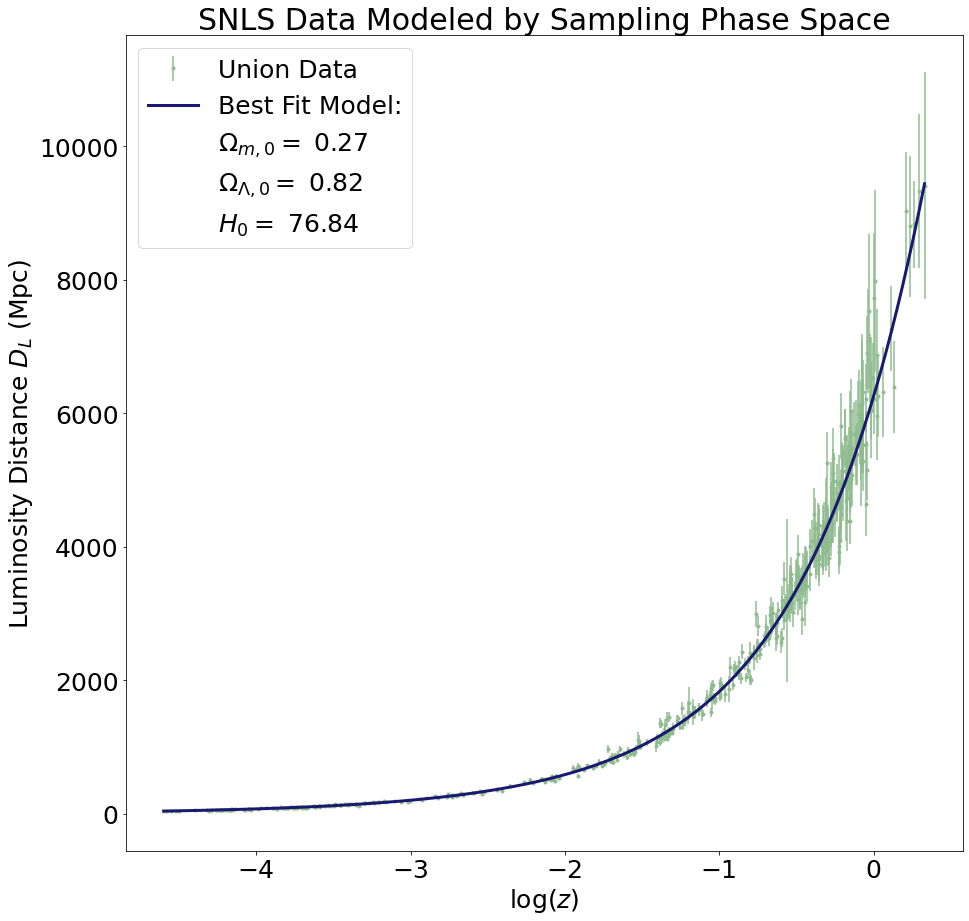

In [61]:
zz = np.linspace(np.min(redshift),np.max(redshift),1000)
plt.figure(figsize = (15,15))

plt.errorbar(np.log(redshift),lum_dist,yerr=lum_dist_err,fmt='.',color='darkseagreen',label="Union Data")
plt.errorbar(np.log(zz),D_L_helper(zz, omega_m_best, omega_lambda_best, H_0_best), linewidth=3,color='midnightblue',label="Best Fit Model:")
plt.errorbar(0,0,linewidth=0,label="$\Omega_{{m,0}}=$ {0:.2f}".format(omega_m_best))
plt.errorbar(0,0,linewidth=0,label="$\Omega_{{\Lambda,0}}=$ {0:.2f}".format(omega_lambda_best))
plt.errorbar(0,0,linewidth=0,label="$H_0=$ {0:.2f}".format(H_0_best))
plt.xlabel("$\log(z)$")
plt.ylabel("Luminosity Distance $D_L$ (Mpc)")
plt.legend()
plt.title("SNLS Data Modeled by Sampling Phase Space");


Now that we know the $\chi^2$ value for each point we sampled from the phase space, we can compute the reduced $\chi^2$ value, which is given by
$$\tilde{\chi}^2 = \frac{\chi^2}{\nu}$$

where $\nu$ is the difference between the number of data points and the number of parameters used to fit the data. We will illustrate how the $\tilde{\chi}^2$ value changes across phase space using a color gradient in the plot below.

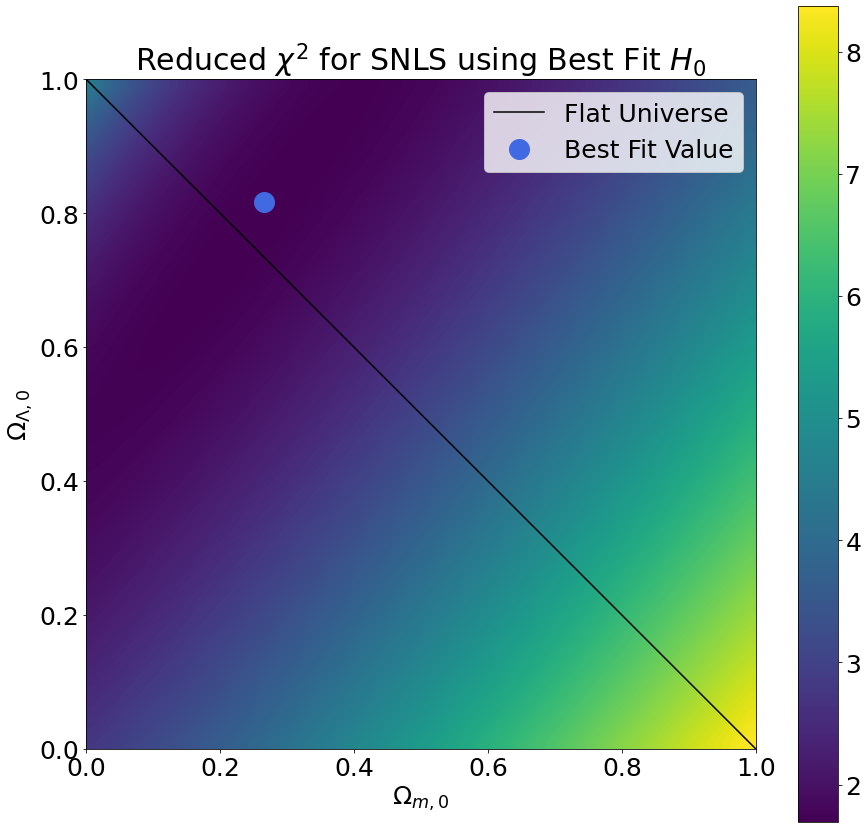

In [65]:
reduced_chi2 = np.transpose(chi2_arr / (np.size(redshift) - 3))
plt.figure(figsize = (15,15))

plt.imshow(reduced_chi2,interpolation='bilinear',origin='lower',extent=(0,1,0,1))
plt.colorbar()
plt.plot(np.array([0,1]),1-np.array([0,1]),color='black',label='Flat Universe')
plt.xlabel("$\Omega_{m,0}$")
plt.ylabel("$\Omega_{\Lambda,0}$")
plt.title("Reduced $\chi^2$ for SNLS using Best Fit $H_0$")
plt.plot(omega_m_best,omega_lambda_best,'o',color='royalblue',label='Best Fit Value', markersize = 20)
plt.legend();

In general, the probability distribution function (PDF) for a chi-squared value is given by
$$p(x,k) = \frac{1}{2^{k/2}\Gamma\left(\frac{k}{2}\right)}x^{k/2-1}e^{-\frac{x}{2}}$$

where $x$ is the chi-squared value, $k$ is the number of fit parameters, and $\Gamma$ is the gamma function. We will evaluate the PDF for our chi-squared values using the ``scipy.stats.chi2.pdf`` function.

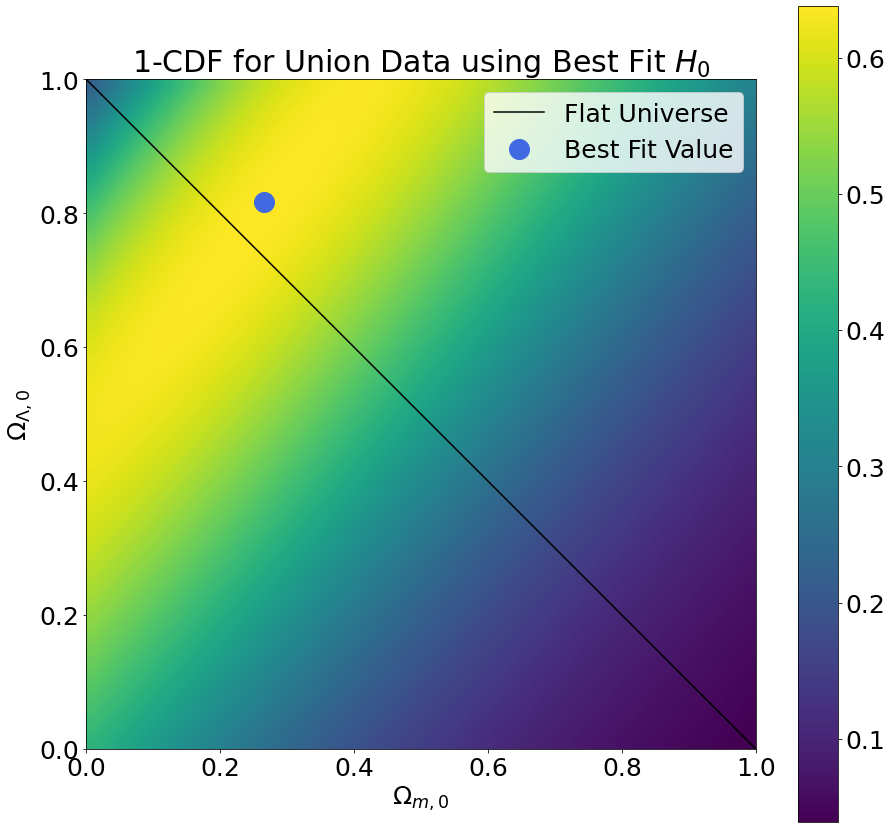

In [78]:
prob =1-c2.cdf((reduced_chi2),(3))
plt.figure(figsize = (15,15))

plt.imshow(prob,interpolation='bilinear',origin='lower',extent=(0,1,0,1))
plt.colorbar()
plt.plot(np.array([0,1]),1-np.array([0,1]),color='black',label='Flat Universe')
plt.xlabel("$\Omega_{m,0}$")
plt.ylabel("$\Omega_{\Lambda,0}$")
plt.title("1-CDF for Union Data using Best Fit $H_0$")
plt.plot(omega_m_best,omega_lambda_best,'o',color='royalblue',label='Best Fit Value', markersize = 20)
plt.legend();

This phase space plot has a similar shape to those in Figures 5, 7, 8, and 9 of Perlmutter et al. (1998). Because the probabilities are concentrated in the upper left quadrant, we will repeat the phase space sampling over the following smaller range to obtain better resolution:
$$\Omega_{m,0}\in[0.1,0.6], \quad \Omega_{\Lambda,0}\in[0.5,1]$$

In [85]:
num_points = 50

omega_m_range = np.linspace(0.1,0.6,num_points)
omega_lambda_range = np.linspace(0.5,1,num_points)

omega_m_best = omega_m_range[0]
omega_lambda_best = omega_lambda_range[0]
expected = D_L_helper(redshift, omega_m, omega_lambda, H_0_best)
chi2_best = np.sum((lum_dist - expected)**2/lum_dist_err**2)
k_best = 0

chi2_arr = np.zeros((num_points,num_points))

for i in np.arange(np.size(omega_m_range)):
    for j in np.arange(np.size(omega_lambda_range)):
            omega_m = omega_m_range[i]
            omega_lambda = omega_lambda_range[j]
            expected = D_L_helper(redshift, omega_m, omega_lambda, H_0_best)
            chi2 = np.sum((lum_dist - expected)**2/lum_dist_err**2)
            chi2_arr[i][j] = chi2
            if chi2 < chi2_best:
                omega_m_best = omega_m
                omega_lambda_best = omega_lambda
                chi2_best = chi2
                k_best = k
                
print("Matter density: ", "{0:.2f}".format(omega_m_best))
print("Dark energy density: ", "{0:.2f}".format(omega_lambda_best))
print("Hubble constant: ", "{0:.2f}".format(H_0_best))

Matter density:  0.25
Dark energy density:  0.80
Hubble constant:  76.84


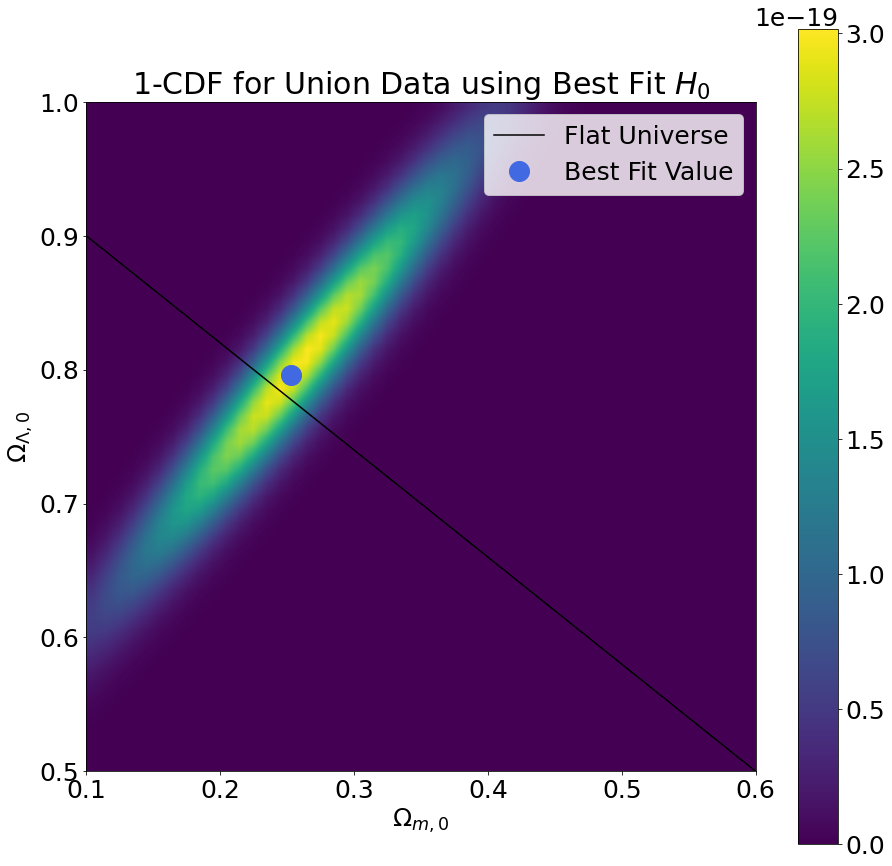

In [86]:
prob =c2.sf(np.transpose(chi2_arr),(len(redshift)-3))
plt.figure(figsize = (15,15))

plt.imshow(prob,interpolation='bilinear',origin='lower',extent=(0.1,0.6,0.5,1))
plt.colorbar()
plt.plot(np.array([0.1,0.6]),np.array([0.9,0.5]),color='black',label='Flat Universe')
plt.xlabel("$\Omega_{m,0}$")
plt.ylabel("$\Omega_{\Lambda,0}$")
plt.title("1-CDF for Union Data using Best Fit $H_0$")
plt.plot(omega_m_best,omega_lambda_best,'o',color='royalblue',label='Best Fit Value', markersize = 20)
plt.legend();

This plot clearly shows the shape of the probability distribution in phase space. So far, we have only evaluated the PDF at some representative points in phase space. To make the numbers more meaningful, we will rescale the probabilities such that the value on the colorbar corresponds to the probability to land in a particular region *relative to the probability of the best-fit point* (i.e., the best fit point has a scaled probability of $1$, and a point whose probability is half that of the best-fit point has a scaled probability of $0.5$).

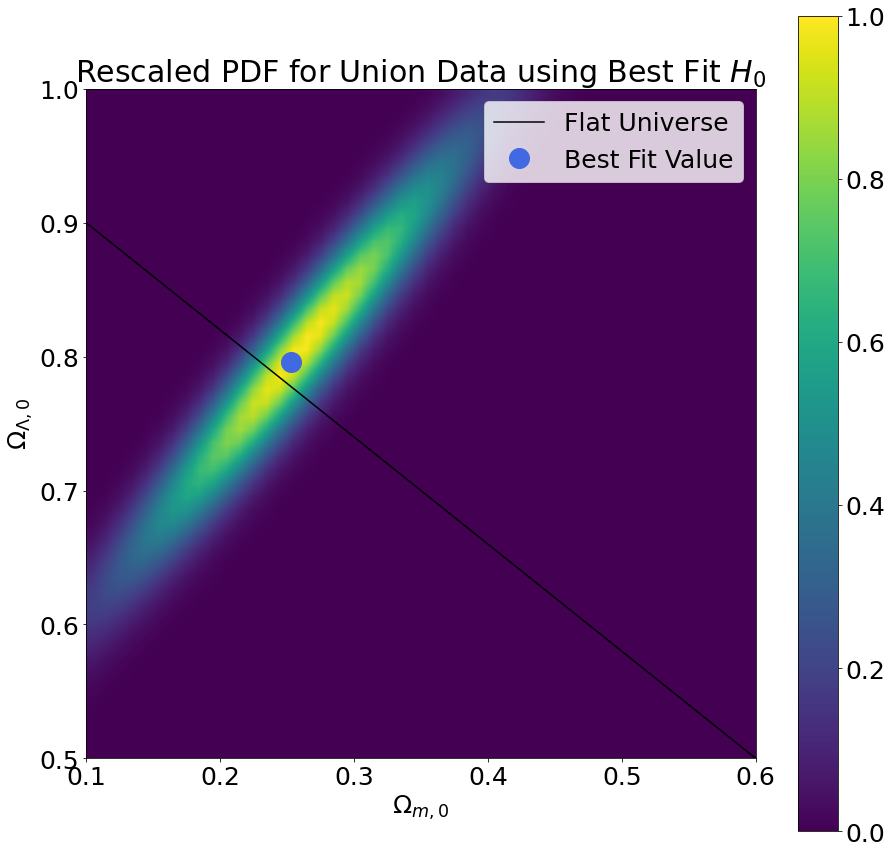

In [96]:
max_prob = np.max(prob)
scaled_prob = prob/max_prob
plt.figure(figsize = (15,15))

plt.imshow(scaled_prob,interpolation='bilinear',origin='lower',extent=(0.1,0.6,0.5,1))
plt.colorbar()
plt.plot(np.array([0.1,0.6]),np.array([0.9,0.5]),color='black',label='Flat Universe')
plt.xlabel("$\Omega_{m,0}$")
plt.ylabel("$\Omega_{\Lambda,0}$")
plt.title("Rescaled PDF for Union Data using Best Fit $H_0$")
plt.plot(omega_m_best,omega_lambda_best,'o',color='royalblue',label='Best Fit Value', markersize = 20)
plt.legend();

## Scale Factor Integration

At this point, we have calculated the best fit values of the cosmological parameters $\Omega_{m,0}$, $\Omega_{\Lambda,0}$, and $H_0$. With these parameters fixed, we can use the Friedmann equation to determine how the system will evolve in time. For an approximately flat matter- and dark energy-dominated universe, the Friedmann equation takes the following form:
$$\frac{\dot{a}^2}{a^2} = H_0^2\left[\frac{\Omega_{m,0}}{a^3} + \Omega_{\Lambda,0}\right]$$
$$\frac{da}{dt} = H_0 \sqrt{\frac{\Omega_{m,0}}{a} + \Omega_{\Lambda,0}a^2}$$

To test that our integration is working, we will first consider a matter-only universe, for which the Friedmann equation can be solved by hand.
$$\frac{da}{dt} = H_0 \sqrt{\frac{\Omega_{m,0}}{a}}$$
$$\sqrt{a}da = H_0\sqrt{\Omega_{m,0}}dt$$
$$\int_0^{a(t)} \sqrt{a}da = H_0 \sqrt{\Omega_{m,0}}\int_0^t dt$$
$$\frac{2}{3}a(t)^{\frac{3}{2}} = H_0\sqrt{\Omega_{m,0}}t$$
$$a(t) = \left(\frac{3}{2}H_0\sqrt{\Omega_{m,0}}t\right)^{\frac{2}{3}}$$

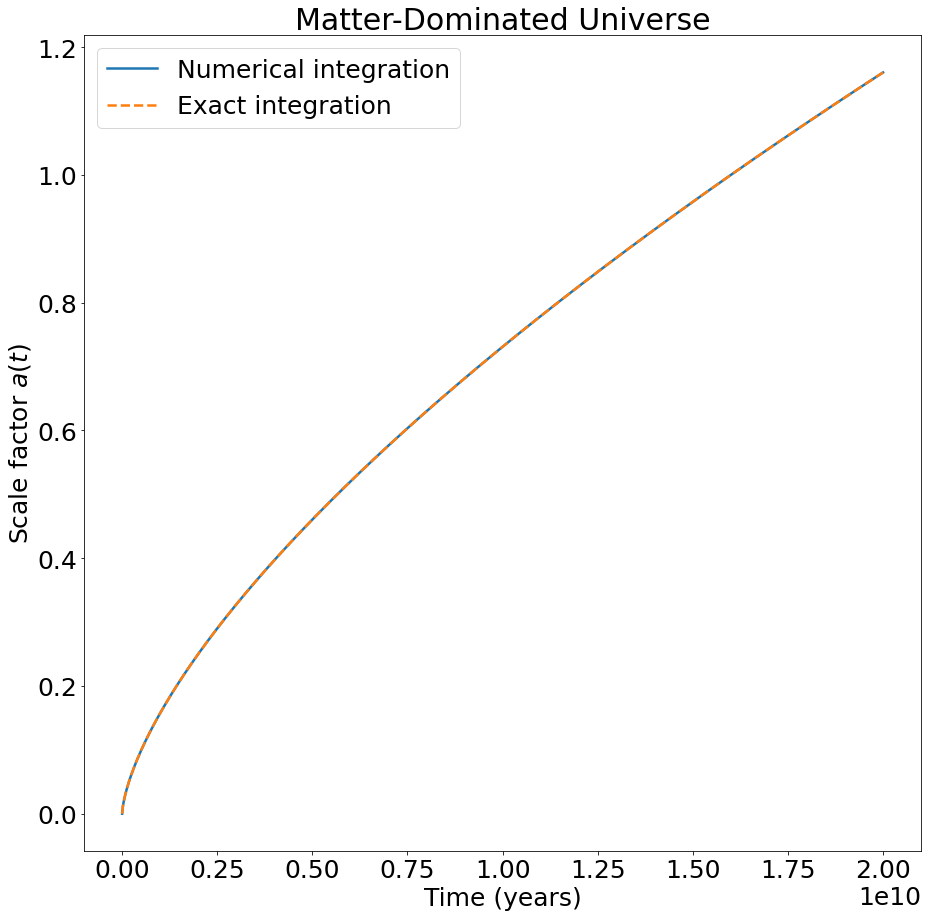

In [88]:
t_range = 0,20e9 # in units of t0
a0 = np.array([1e-15]) # pick some small but nonzero value
H_0_yrs = H_0_fit / 3.086e19 * 3.154e7 # convert H_0 to units of 1/years
adot = lambda time, a: H_0_yrs * np.sqrt(omega_m_fit/a)
rel_err_tolerance = 1e-5
t_eval = np.linspace(0,20e9,1000)

soln = integrate.solve_ivp(adot, t_range, a0, rtol=rel_err_tolerance, t_eval=t_eval)
times = soln.t
matter_num = soln.y[0]

matter_exact = (3/2 * H_0_yrs * np.sqrt(omega_m_fit
                                       ) * times)**(2/3)
plt.figure(figsize = (15,15))

plt.plot(times, matter_num, label='Numerical integration',linewidth=2.5)
plt.plot(times, matter_exact, '--', label='Exact integration',linewidth=2.5)
plt.xlabel("Time (years)")
plt.ylabel("Scale factor $a(t)$")
plt.legend()
plt.title("Matter-Dominated Universe");

In the plot above, the scale factors obtained using numerical and exact integration coincide with each other, which is a sign that our numerical integrator is working well. We can perform a similar test for a single-component universe containing only dark energy. In that case, the Friedmann equation simplifies as follows.
$$\frac{da}{dt} = H_0\sqrt{\Omega_{\Lambda,0}}a$$
$$\frac{1}{a}da = H_0\sqrt{\Omega_{\Lambda,0}}dt$$
$$\int_{a(0)}^{a(t)} \frac{1}{a}da = H_0\sqrt{\Omega_{\Lambda,0}}\int_0^tdt$$
$$\ln{\left(\frac{a(t)}{a(0)}\right)} = H_0\sqrt{\Omega_{\Lambda,0}}t$$
$$a(t) = a(0)\cdot e^{H_0\sqrt{\Omega_{\Lambda,0}}t}$$

We cannot set $a(t) = a(0)$ because then $a(t)$ would remain zero for all times. Instead, to solve for the integration constant $a(0)$ we will impose the condition $a(t_0) = 1$ where $t_0 = t_H = \frac{1}{H_0}$. 
$$a(0) = a(t_0) e^{-H_0\sqrt{\Omega_{\Lambda,0}}t_0} = e^{-\sqrt{\Omega_{\Lambda,0}}}$$
$$a(t) = e^{\sqrt{\Omega_{\Lambda_0}} \left( H_0 t - 1\right)}$$

Now let's go ahead and integrate the scale factor for a dark energy-dominated universe using both the exact solution calculated above and numerical integration.

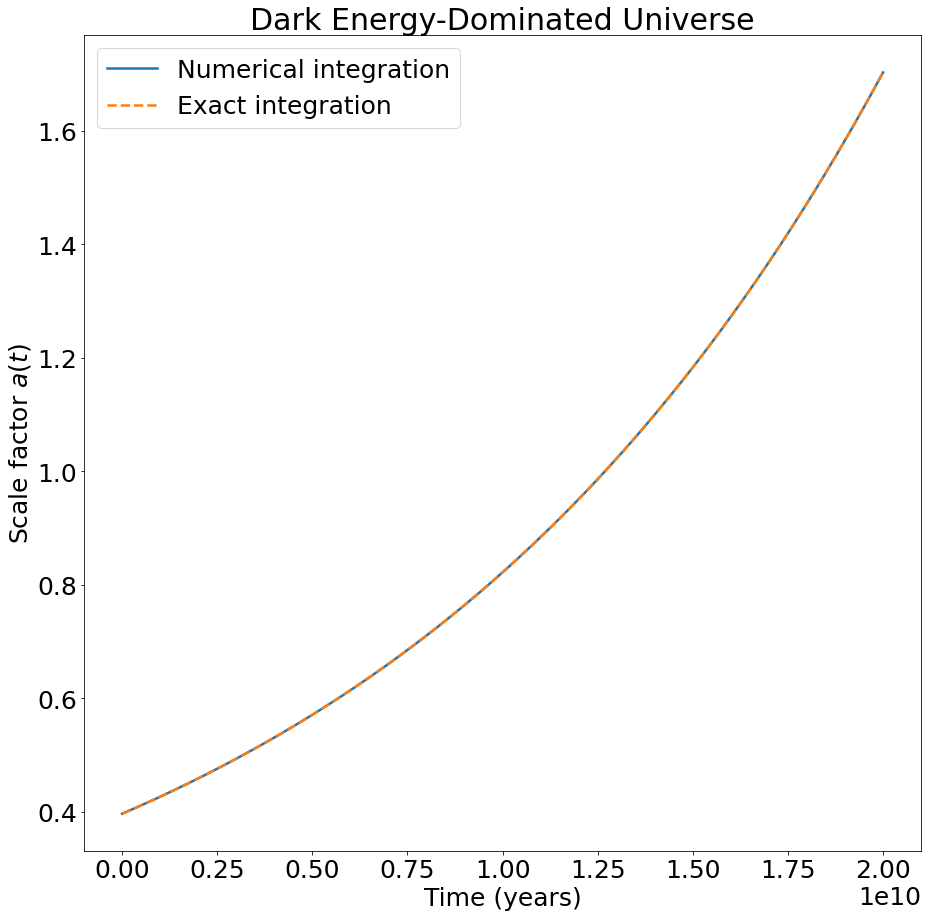

In [89]:
t_range = 0,20e9 # in units of t0
a0 = np.array([np.exp(-np.sqrt(omega_lambda_fit))])
H_0_yrs = H_0_fit / 3.086e19 * 3.154e7 # convert H_0 to units of 1/years
adot = lambda time, a: H_0_yrs * np.sqrt(omega_lambda_fit) * a
rel_err_tolerance = 1e-5
t_eval = np.linspace(0,20e9,1000)

soln = integrate.solve_ivp(adot, t_range, a0, rtol=rel_err_tolerance, t_eval=t_eval)
times = soln.t
de_num = soln.y[0]

de_exact = np.exp(np.sqrt(omega_lambda_fit) * (H_0_yrs * times - 1))
plt.figure(figsize = (15,15))

plt.plot(times, de_num, label='Numerical integration',linewidth=2.5)
plt.plot(times, de_exact, '--', label='Exact integration',linewidth=2.5)
plt.xlabel("Time (years)")
plt.ylabel("Scale factor $a(t)$")
plt.legend()
plt.title("Dark Energy-Dominated Universe");

The curves for the scale factor obtained using numerical integration and exact integration coincide, which indicates that our numerical integration is working well. We are now ready to integrate the full Friedmann equation, including both matter and dark energy terms. For comparison, we will also include the scale factors for the scale factor for the matter-only universe on the same plot. However, because the dark energy-only universe uses a different constraint ($a(t_0) = 1$ rather than $a(0)=0$), we will omit the dark energy-only universe from the plot.

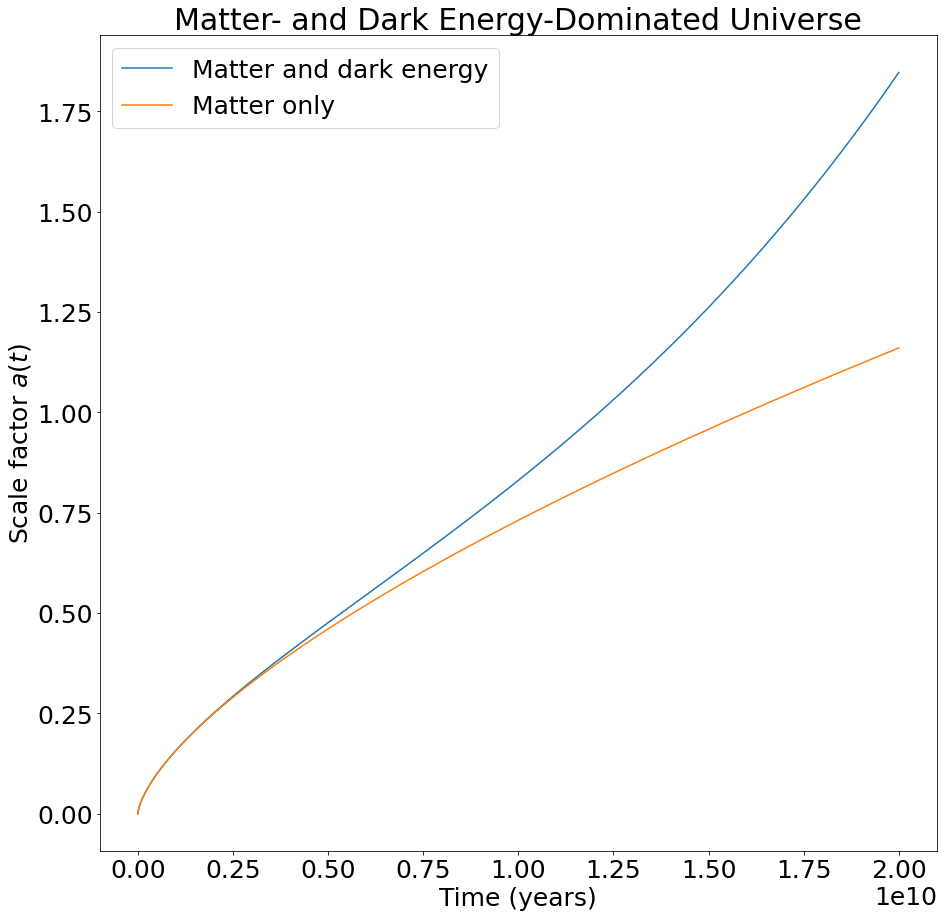

In [90]:
t_range = 0,20e9 # in units of t0
a0 = np.array([1e-15]) # pick some small but nonzero value
H_0_yrs = H_0_fit / 3.086e19 * 3.154e7 # convert H_0 to units of 1/years
adot = lambda time, a: H_0_yrs * np.sqrt(omega_m_fit/a + omega_lambda_fit * a**2)
rel_err_tolerance = 1e-5
t_eval = np.linspace(0,20e9,1000)

soln = integrate.solve_ivp(adot, t_range, a0, rtol=rel_err_tolerance, t_eval=t_eval)
times = soln.t
total_num = soln.y[0]
plt.figure(figsize = (15,15))

plt.plot(times, total_num, label='Matter and dark energy')
plt.plot(times, matter_exact, label='Matter only')
#plt.plot(times, de_exact, label='Dark energy only')
plt.xlabel("Time (years)")
plt.ylabel("Scale factor $a(t)$")
plt.title("Matter- and Dark Energy-Dominated Universe")
plt.legend();

Unfortunately, the Friedmann equation including both $\Omega_{m,0}$ and $\Omega_{\Lambda,0}$ cannot easily be integrated by hand to check the results of the numerical integration. However, we obtained the following exact solution from Wolfram Alpha:
$$a(t) = \frac{\sqrt[3]{\Omega_{m,0}}\tanh^{\frac{2}{3}}{\left(\frac{3}{2}\left(C\sqrt{\Omega_{\Lambda,0}} + H_0\sqrt{\Omega_{\Lambda,0}} t\right)\right)}}{\sqrt[3]{\Omega_{L,0} - \Omega_{L,0}\tanh^2{\left(\frac{3}{2}\left(C\sqrt{\Omega_{\Lambda,0}}+H_0\sqrt{\Omega_{\Lambda,0}} t\right)\right)}}}$$

Since the Friedmann equation is a first-order differential equation, we expect one constant of integration. This constant $C$ is fixed by the initial condition $a(0) = 0$. Observe that
$$a(0) = \frac{\sqrt[3]{\Omega_{m,0}}\tanh^{\frac{2}{3}}{\left(\frac{3}{2}C\sqrt{\Omega_{\Lambda,0}} \right)}}{\sqrt[3]{\Omega_{L,0} - \Omega_{L,0}\tanh^2{\left(\frac{3}{2}C\sqrt{\Omega_{\Lambda,0}}\right)}}}= 0$$

The hyperbolic tangent function vanishes at $0$, so we can let $C=0$ to ensure the initial condition $a(0) = 0$ will be satisfied. Therefore, the exact solution fitted to initial conditions is
$$a(t) = \frac{\sqrt[3]{\Omega_{m,0}}\tanh^{\frac{2}{3}}{\left(\frac{3}{2} H_0\sqrt{\Omega_{\Lambda,0}} t\right)}}{\sqrt[3]{\Omega_{L,0} - \Omega_{L,0}\tanh^2{\left(\frac{3}{2}H_0\sqrt{\Omega_{\Lambda,0}} t\right)}}}$$

Let's implement this exact solution in a function and plot it against the solution obtained using numerical integration.

In [91]:
def a(t,omega_m,omega_lambda,H_0):
    num = omega_m**(1/3) * np.tanh(3/2 * H_0 * np.sqrt(omega_lambda) * t)**(2/3)
    den = (omega_lambda - omega_lambda * np.tanh(3/2 * H_0 * np.sqrt(omega_lambda) * t)**2)**(1/3)
    return num/den

In [92]:
def a_helper(times,omega_m,omega_lambda,H_0):
    return [a(t,omega_m,omega_lambda,H_0) for t in times]

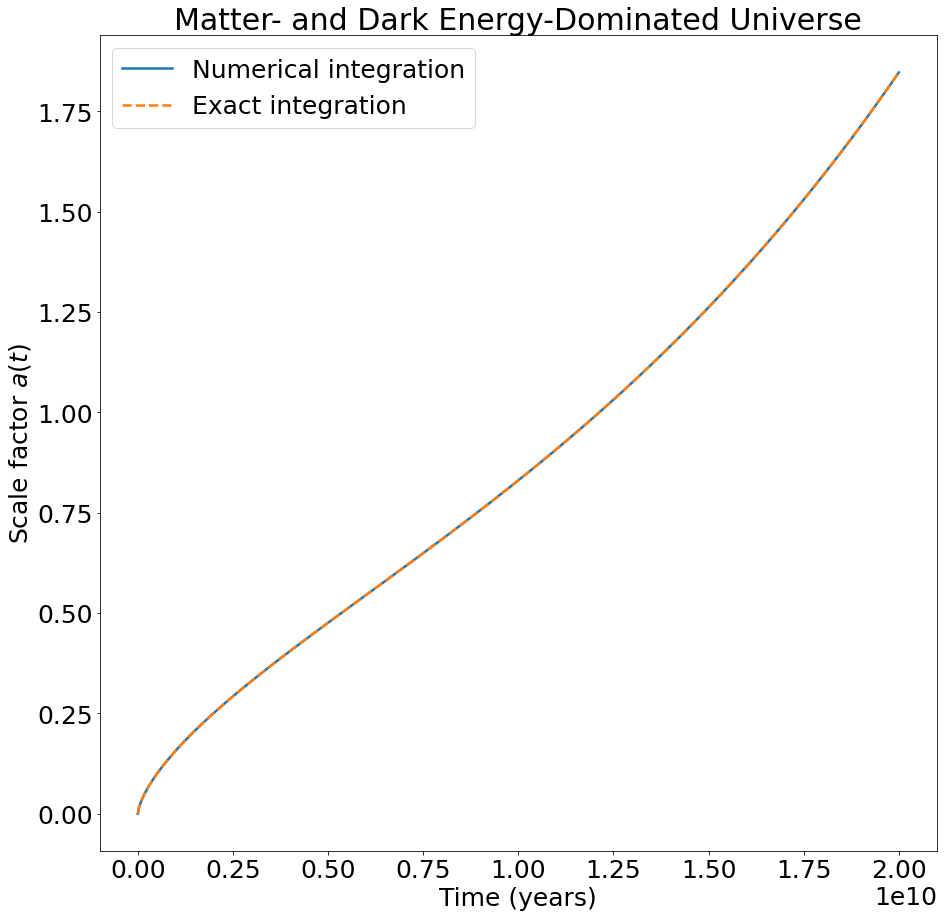

In [93]:
total_exact = a_helper(times,omega_m_fit,omega_lambda_fit,H_0_yrs)
plt.figure(figsize = (15,15))

plt.plot(times, total_num, label='Numerical integration',linewidth=2.5)
plt.plot(times, total_exact, '--', label='Exact integration',linewidth=2.5)
plt.xlabel("Time (years)")
plt.ylabel("Scale factor $a(t)$")
plt.title("Matter- and Dark Energy-Dominated Universe")
plt.legend();

This curve obtained using exact integration for the matter- and dark energy-dominated universe looks very similar to the curve obtained using numerical integration. Indeed,  when we plot the two solutions together we see that the two curves lie on top of each other. This provides confirmation that our scale factor integrator is working properly.

Lastly, we will consider the case of an empty universe, for which the Friedman equation takes the following form.
$$\frac{\dot{a}^2}{a^2} = -H_0^2 \frac{\Omega_0-1}{a^2} = \frac{H_0^2}{a^2}$$

From this equation, we can see that
$$\dot{a} = H_0$$
$$a(t) = H_0 t + C$$

where $C$ is an arbtirary integration constant. If we impose the condition $a(0) = 0$, then the integration constant must vanish and we are left with $a(t) = H_0 t$. The scale factor for an empty universe is added to the previous plot in the cell below.

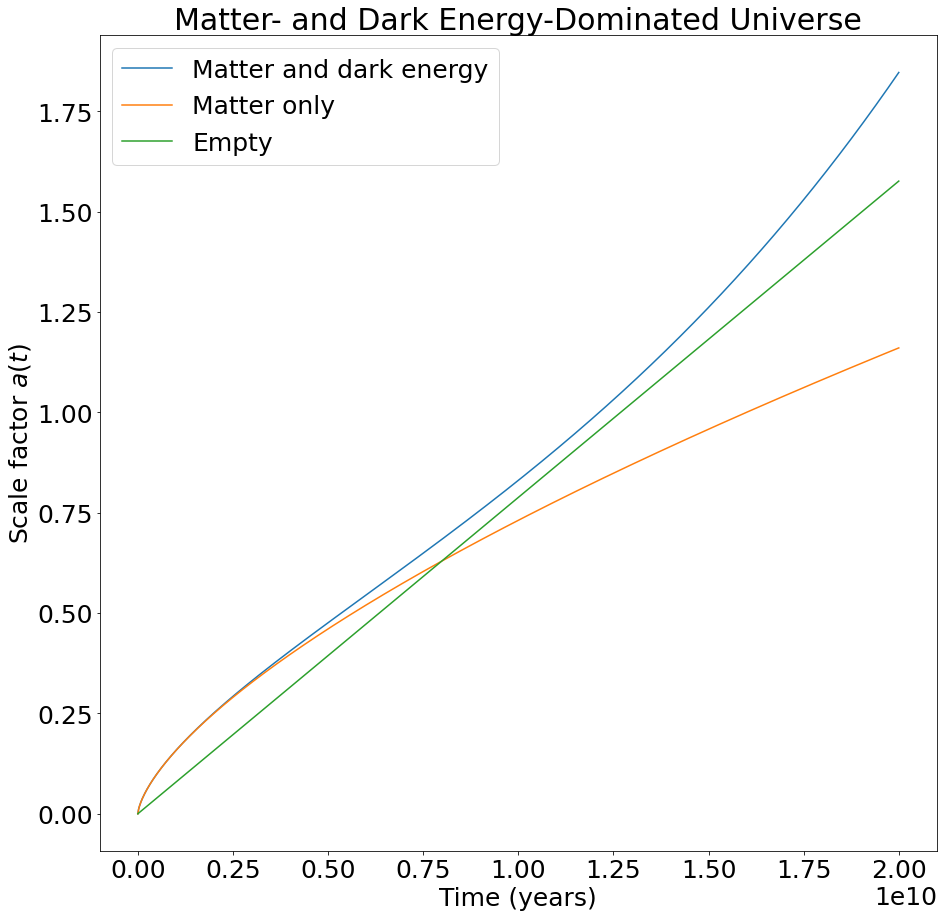

In [94]:
empty = H_0_yrs * times
plt.figure(figsize = (15,15))

plt.plot(times, total_exact,label='Matter and dark energy')
plt.plot(times, matter_exact, label='Matter only')
plt.plot(times, empty, label='Empty')
plt.xlabel("Time (years)")
plt.ylabel("Scale factor $a(t)$")
plt.title("Matter- and Dark Energy-Dominated Universe")
plt.legend();

For these three universes, we have imposed the condition $a(0)=0$, but we have not explicitly required that $a(t_0)=1$. Instead, we can interpret the time at which $a(t)=1$ as the present age of the universe in each of the three models. The following cell computes these times.

In [95]:
t0_m_index = 0
t0_total_index = 0
t0_empty_index = 0

for i in range(len(times)):
    if np.abs(1-matter_exact[i]) < np.abs(1-matter_exact[t0_m_index]):
        t0_m_index = i
    if np.abs(1-total_exact[i]) < np.abs(1-total_exact[t0_total_index]):
        t0_total_index = i
    if np.abs(1-empty[i]) < np.abs(1-empty[t0_empty_index]):
        t0_empty_index = i
        
print("Present time (matter-only universe): {0:.2E}".format(times[t0_m_index]))
print("Present time (matter and dark energy universe): {0:.2E}".format(times[t0_total_index]))
print("Present time (empty universe): {0:.2E}".format(times[t0_empty_index]))
print("Hubble time (1/H_0): {0:.2E}".format(1/H_0_yrs))

Present time (matter-only universe): 1.60E+10
Present time (matter and dark energy universe): 1.21E+10
Present time (empty universe): 1.27E+10
Hubble time (1/H_0): 1.27E+10
